In [1]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [2]:
parser = hlp.sklearn_eval.SearchCVParser.from_yaml_file(yaml_file_name = 'Run 1 - Stacking - BayesSearchCV.yaml')
parser.best_primary_score_params

{'colsample_bytree': 0.01,
 'learning_rate': 0.06159811010986713,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.5}

In [3]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)
    print(X_train.shape)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)
    print(len(y_train))

with open('../X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    print(X_test.shape)

with open('../y_test.pkl', 'rb') as handle:
    y_test = pickle.load(handle)
    print(len(y_test))

(800, 20)
800
(200, 20)
200


In [4]:
X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,NaN,NaN,delayed previously,business,0.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes
557,no checking,21.0,no credits/all paid,new car,5003.0,no known savings,1<=X<4,1.0,female div/dep/mar,none,4.0,life insurance,29.0,bank,own,2.0,skilled,1.0,yes,yes
836,no checking,12.0,existing paid,radio/tv,886.0,no known savings,1<=X<4,4.0,female div/dep/mar,none,2.0,car,21.0,none,own,1.0,skilled,1.0,none,yes


In [5]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [6]:
X_test.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
737,<0,18.0,existing paid,new car,4380.0,100<=X<500,1<=X<4,3.0,male single,none,4.0,car,35.0,none,own,1.0,unskilled resident,2.0,yes,yes
740,<0,24.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,none,3.0,car,32.0,bank,own,1.0,skilled,1.0,none,yes
660,>=200,12.0,existing paid,radio/tv,1297.0,<100,1<=X<4,3.0,male mar/wid,none,4.0,real estate,23.0,none,rent,1.0,skilled,1.0,none,yes
411,no checking,33.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,none,2.0,car,35.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes


In [7]:
y_test[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Training and Test Data

In [8]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [9]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


# Model

In [10]:
parser.best_primary_score_params

{'colsample_bytree': 0.01,
 'learning_rate': 0.06159811010986713,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.5}

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

logistic_estimator = make_pipeline(
    ColumnTransformer([
        (
            'numeric',
            make_pipeline(
                SimpleImputer(strategy='mean'),
#                 StandardScaler()
            ),
            numeric_columns
        ),
        (
            'non_numeric',
            make_pipeline(OneHotEncoder()),
            non_numeric_columns
        )
    ]),
    LogisticRegression(
        C=0.21380623392192172,
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
)

rf_estimator = make_pipeline(
    ColumnTransformer([
        (
            'numeric',
            make_pipeline(
                SimpleImputer(strategy='mean'),
                #StandardScaler()
            ),
            numeric_columns
        ),
        (
            'non_numeric',
            make_pipeline(hlp.sklearn_pipeline.CustomOrdinalEncoder()),
            non_numeric_columns
        )
    ]),
    RandomForestClassifier(
        max_features=0.001,
        n_estimators=2186,
        random_state=42,
    )
)


xgb_estimator = make_pipeline(
    ColumnTransformer([
        (
            'numeric',
            make_pipeline(
                SimpleImputer(strategy='mean'),
                StandardScaler()
            ),
            numeric_columns
        ),
        (
            'non_numeric',
            make_pipeline(hlp.sklearn_pipeline.CustomOrdinalEncoder()),
            non_numeric_columns
        )
    ]),
    XGBClassifier(
        colsample_bytree=0.01,
        learning_rate=0.06159811010986713,
        max_depth=3,
        n_estimators=50,
        subsample=0.5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
)

estimators = [
    ('logistic', logistic_estimator),
    ('rf', rf_estimator),
    ('xgb', xgb_estimator),
]

from sklearn.ensemble import StackingClassifier
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [12]:
#stacking_model.get_params()

In [13]:
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('logistic',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('numeric',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer())]),
                                                                                  ['duration',
                                                                                   'credit_amount',
                                                                                   'installment_commitment',
                                                                                   'residence_since',
                                                                                   'age',
                                                              

In [14]:
# fitted_pipeline.predict(X_test)
# fitted_pipeline.predict_proba(X_test)
# y_test

## Training Set Evaluation

Understand the nature/degree of model overfitting by comparing to `Test Set Evaluation`

In [15]:
predicted_scores = stacking_model.predict_proba(X_train)[:, 1]

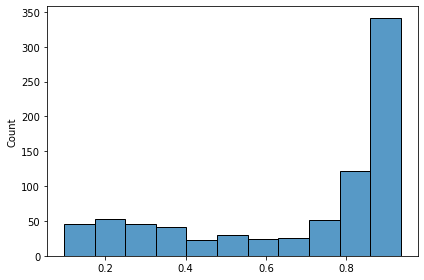

In [16]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [17]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_train,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

In [18]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.999,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.998,"99.8% of positive instances were correctly identified.; i.e. 558 ""Good"" labels were correctly identified out of 559 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.876,"87.6% of negative instances were correctly identified.; i.e. 211 ""Bad"" labels were correctly identified out of 241 instances"
False Positive Rate,0.124,"12.4% of negative instances were incorrectly identified as positive; i.e. 30 ""Bad"" labels were incorrectly identified as ""Good"", out of 241 instances"
False Negative Rate,0.002,"0.2% of positive instances were incorrectly identified as negative; i.e. 1 ""Good"" labels were incorrectly identified as ""Bad"", out of 559 instances"
Positive Predictive Value,0.949,"When the model claims an instance is positive, it is correct 94.9% of the time; i.e. out of the 588 times the model predicted ""Good"", it was correct 558 times; a.k.a precision"
Negative Predictive Value,0.995,"When the model claims an instance is negative, it is correct 99.5% of the time; i.e. out of the 212 times the model predicted ""Bad"", it was correct 211 times"
F1 Score,0.973,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.961,96.1% of instances were correctly identified
Error Rate,0.039,3.9% of instances were incorrectly identified


In [19]:
del predicted_scores

## Test Set Evaluation

In [20]:
predicted_scores = stacking_model.predict_proba(X_test)[:, 1]

In [21]:
predicted_scores[0:10]

array([0.57709602, 0.58642826, 0.29163501, 0.68964467, 0.88938398,
       0.70232064, 0.90311447, 0.55262488, 0.8869297 , 0.85137052])

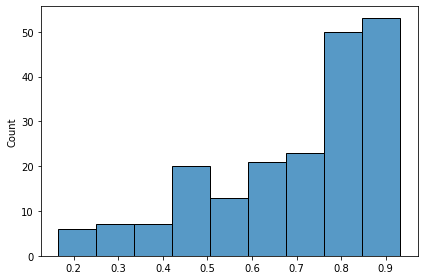

In [22]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [23]:
y_test_cat = pd.Series(y_test).replace({1: 'Defaulted', 0: 'Not Defaulted'})
y_test_cat.head()

0    Not Defaulted
1        Defaulted
2        Defaulted
3        Defaulted
4        Defaulted
dtype: object

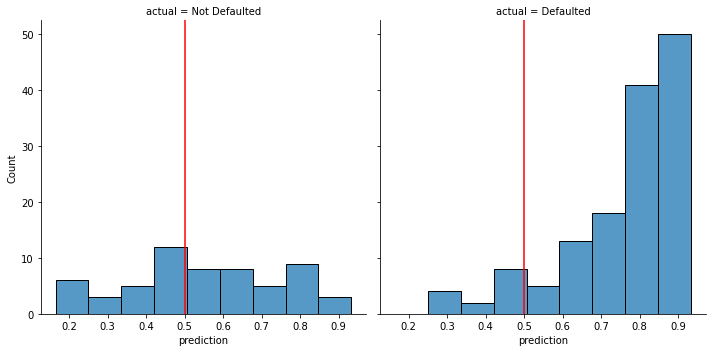

In [24]:
axes = sns.displot(
    pd.DataFrame({
        'prediction': predicted_scores,
        'actual': y_test_cat
    }),
    x='prediction',
    col='actual'
)
for axis in axes.axes.flat:
    axis.axvline(x=0.5, ymin=0, ymax=100, color='red')
plt.tight_layout()

In [25]:
del y_test_cat
del axes

In [26]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

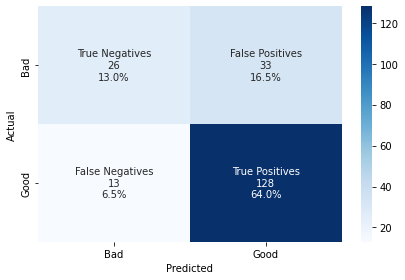

In [27]:
evaluator.plot_confusion_matrix()

In [28]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.801,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.908,"90.8% of positive instances were correctly identified.; i.e. 128 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.441,"44.1% of negative instances were correctly identified.; i.e. 26 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,0.559,"55.9% of negative instances were incorrectly identified as positive; i.e. 33 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.092,"9.2% of positive instances were incorrectly identified as negative; i.e. 13 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.795,"When the model claims an instance is positive, it is correct 79.5% of the time; i.e. out of the 161 times the model predicted ""Good"", it was correct 128 times; a.k.a precision"
Negative Predictive Value,0.667,"When the model claims an instance is negative, it is correct 66.7% of the time; i.e. out of the 39 times the model predicted ""Bad"", it was correct 26 times"
F1 Score,0.848,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.770,77.0% of instances were correctly identified
Error Rate,0.230,23.0% of instances were incorrectly identified


Compare results against scores if we predicted all `Good`

In [29]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [30]:
dummy_eval = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.500,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 141 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.000,"0.0% of negative instances were correctly identified.; i.e. 0 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,1.000,"100.0% of negative instances were incorrectly identified as positive; i.e. 59 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.705,"When the model claims an instance is positive, it is correct 70.5% of the time; i.e. out of the 200 times the model predicted ""Good"", it was correct 141 times; a.k.a precision"
Negative Predictive Value,0.000,"When the model claims an instance is negative, it is correct 0.0% of the time; i.e. out of the 0 times the model predicted ""Bad"", it was correct 0 times"
F1 Score,0.827,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.705,70.5% of instances were correctly identified
Error Rate,0.295,29.5% of instances were incorrectly identified


In [42]:
fig = evaluator.plot_auc_curve(return_plotly=True)
fig.show()

<Figure size 720x444.984 with 0 Axes>

In [43]:
fig = evaluator.plot_threshold_curves(return_plotly=True)
fig.show()

<Figure size 720x444.984 with 0 Axes>

In [44]:
fig = evaluator.plot_precision_recall_tradeoff(score_threshold_range=(0.4, 0.95),
                                               return_plotly=True)
fig.show()

<Figure size 720x444.984 with 0 Axes>

In [38]:
evaluator.calculate_lift_gain(return_style=True, include_all_info=True)

,# of Obs.,# of Pos. Events,Cumul. Pos. Events,Gain,Lift
Percentile,,,,,
5,10,10,10,0.07,1.42
10,10,10,20,0.14,1.42
15,10,9,29,0.21,1.37
20,10,10,39,0.28,1.38
25,10,8,47,0.33,1.33
30,10,7,54,0.38,1.28
35,10,9,63,0.45,1.28
40,10,10,73,0.52,1.29
45,10,6,79,0.56,1.25


In [39]:
del predicted_scores

# Feature Importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [40]:
from sklearn.inspection import permutation_importance
import time

estimator = stacking_model

start_time = time.time()
result = permutation_importance(
    estimator, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

feature_names = X_train.columns.to_list()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

Elapsed time to compute the importances: 35.164 seconds


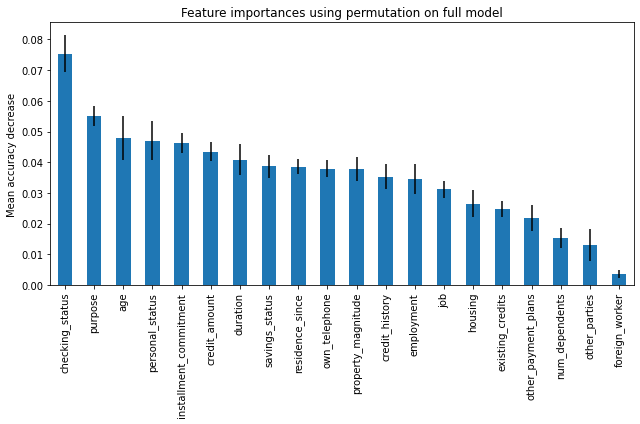

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(9, 6)
fig.tight_layout()
plt.show()